In [80]:
import numpy as np
import tensorflow as tf

np.random.seed()
# tf.set_random_seed()

'''
CFO Equalizer is a net that, given a known preamble, will take in the convolved preamble and convolved data
that have been passed through a multipath channel, and correct the CFO and equalize the data.
For now we assume that the channel taps are known.
'''

class CFO_Equalizer():
    def __init__(self, preamble_length = 50, data_length = 100, channel_length = 2, 
                 batch_size = 150, learning_rate = 0.01):           
        
        # Network variables
        self.preamble_length = preamble_length
        self.data_length = data_length
        self.channel_length = channel_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # Placeholders for training
        self.preamble_original = tf.placeholder(tf.float32, [None, self.preamble_length, 2])
        self.preamble_convolved = tf.placeholder(tf.float32, [None, self.preamble_length, 2])
        self.data_original = tf.placeholder(tf.float32, [None, self.data_length, 2])
        self.data_convolved = tf.placeholder(tf.float32, [None, self.data_length, 2])
        self.channel = tf.placeholder(tf.float32, [None, self.channel_length,2])
            
        ###############
        # CFO Estimation using preambles
        ###############
        preamble_original_cfo = tf.concat([self.preamble_original, self.preamble_convolved], 1)

        preamble_original_cfo_flat = tf.contrib.layers.flatten(preamble_original_cfo)

        cfo_layer_1 = tf.layers.dense(
          preamble_original_cfo_flat, 100, tf.nn.tanh, use_bias=True)
        cfo_layer_2 = tf.layers.dense(
          cfo_layer_1, 100, tf.nn.tanh, use_bias=True)
        cfo_layer_3 = tf.layers.dense(
          cfo_layer_2, 100, activation=tf.nn.tanh, use_bias=True)
        cfo_layer_4 = tf.layers.dense(
          cfo_layer_3, 1, activation=tf.identity, use_bias=True)

        self.est_omega = cfo_layer_4
        
        
        ###############
        # CFO Correction on the convolved data
        ###############

        data_cfo_complex = tf.complex(self.data_convolved[:,:,0], self.data_convolved[:,:,1])
        data_cfo_complex = tf.expand_dims(data_cfo_complex, -1)

        # build the rotation matrix
        incremented_omega = []
        for i in range(data_length):
            incremented_omega.append(-self.est_omega*i)

        rotation_complex = tf.exp(tf.complex(0.0,tf.transpose(incremented_omega, perm=[1,0,2])))
        data_rotated_complex = tf.multiply(data_cfo_complex,rotation_complex)

        data_rotated = tf.stack([tf.real(data_rotated_complex[:,:]), 
                                     tf.imag(data_rotated_complex[:,:])], axis=2)
        
        data_cfo_corrected = tf.squeeze(data_rotated,-1)
    
        ###############
        # Equalization on the cfo corrected data
        ###############
#         print(data_cfo_corrected[:,:,0,:].get_shape().as_list())
#         print(self.channel[:,:,0,:].get_shape().as_list())
        
        est_data = []
        for val in range(2):
            data_channel_concat = tf.concat([data_cfo_corrected[:,:,val], self.channel[:,:,val]], 1)
#             data_channel_concat.set_shape([None, 102])
            layer_1 = tf.layers.dense(
              data_channel_concat, 400, tf.nn.sigmoid, use_bias=True)
            layer_2 = tf.layers.dense(
              layer_1, 400, tf.nn.sigmoid, use_bias=True)
            layer_3 = tf.layers.dense(
              layer_2, data_length, activation=tf.identity, use_bias=True)

            est_data_part = layer_3
            est_data.append(est_data_part)
            
        self.est_data = tf.transpose(est_data, perm=[1,2,0])

#         print(est_data.get_shape().as_list())    
        
        ###############################################
        # Define surrogate loss and optimization tensor
        ###############################################
        self.surr = tf.losses.mean_squared_error(self.data_original, self.est_data)
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.update_op = self.optimizer.minimize(self.surr)

        ###############
        # Start session
        ###############
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
            

    def test_net(self, preamble_original, preamble_convolved, data_original, data_convolved, channel):
        """
        Test net function. Evaluates the session
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            test_cost, error between the data_original and the estimated data
        """

        test_cost, test_est, test_omega = self.sess.run([self.surr,self.est_data,self.est_omega], feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.data_original: data_original,
                self.data_convolved: data_convolved,
                self.channel: channel
        })
        
        return test_cost,test_est, test_omega
    
            
    def train_net(self, preamble_original, preamble_convolved, data_original, data_convolved, channel):
        """
        Train net function. Calls self.update_op.
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            train_cost, error between the data_original and the estimated data
        """

        _ , train_cost = self.sess.run([self.update_op, self.surr], feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.data_original: data_original,
                self.data_convolved: data_convolved,
                self.channel: channel
        })
        
        return train_cost
    


In [73]:
import numpy as np
import tensorflow as tf

np.random.seed()
# tf.set_random_seed()

'''
CFO Equalizer is a net that, given a known preamble, will take in the convolved preamble and convolved data
that have been passed through a multipath channel, and correct the CFO and equalize the data.
For now we assume that the channel taps are known.
'''

class Equalizer_then_CFO():
    def __init__(self, preamble_length = 50, data_length = 100, channel_length = 2, 
                 batch_size = 150, learning_rate = 0.01):           
        
        # Network variables
        self.preamble_length = preamble_length
        self.data_length = data_length
        self.channel_length = channel_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # Placeholders for training
        self.preamble_original = tf.placeholder(tf.float32, [None, self.preamble_length, 2])
        self.preamble_convolved = tf.placeholder(tf.float32, [None, self.preamble_length, 2])
        self.data_original = tf.placeholder(tf.float32, [None, self.data_length, 2])
        self.data_convolved = tf.placeholder(tf.float32, [None, self.data_length, 2])
        self.channel = tf.placeholder(tf.float32, [None, self.channel_length,2])
            
            
        ###############
        # Equalization on the cfo corrected data
        ###############
#         print(data_cfo_corrected[:,:,0,:].get_shape().as_list())
#         print(self.channel[:,:,0,:].get_shape().as_list())
        
        est_data = []
        for val in range(2):
            data_channel_concat = tf.concat([self.preamble_convolved[:,:,val], self.channel[:,:,val]], 1)
#             data_channel_concat.set_shape([None, 102])
            layer_1 = tf.layers.dense(
              data_channel_concat, 400, tf.nn.sigmoid, use_bias=True)
            layer_2 = tf.layers.dense(
              layer_1, 400, tf.nn.sigmoid, use_bias=True)
            layer_3 = tf.layers.dense(
              layer_2, preamble_length, activation=tf.identity, use_bias=True)

            est_data_part = layer_3
            est_data.append(est_data_part)
            
        self.est_data = tf.transpose(est_data, perm=[1,2,0])

#         print(est_data.get_shape().as_list())        
        
        
        ###############
        # CFO Estimation using preambles
        ###############
        preamble_original_cfo = tf.concat([self.preamble_original, self.est_data], 1)

        preamble_original_cfo_flat = tf.contrib.layers.flatten(preamble_original_cfo)

        cfo_layer_1 = tf.layers.dense(
          preamble_original_cfo_flat, 100, tf.nn.tanh, use_bias=True)
        cfo_layer_2 = tf.layers.dense(
          cfo_layer_1, 100, tf.nn.tanh, use_bias=True)
        cfo_layer_3 = tf.layers.dense(
          cfo_layer_2, 100, activation=tf.nn.tanh, use_bias=True)
        cfo_layer_4 = tf.layers.dense(
          cfo_layer_3, 1, activation=tf.identity, use_bias=True)

        self.est_omega = cfo_layer_4
        
        
        ###############
        # CFO Correction on the convolved data
        ###############

        data_cfo_complex = tf.complex(self.est_data[:,:,0], self.est_data[:,:,1])
        data_cfo_complex = tf.expand_dims(data_cfo_complex, -1)

        # build the rotation matrix
        incremented_omega = []
        for i in range(preamble_length):
            incremented_omega.append(-self.est_omega*i)

        rotation_complex = tf.exp(tf.complex(0.0,tf.transpose(incremented_omega, perm=[1,0,2])))
        data_rotated_complex = tf.multiply(data_cfo_complex,rotation_complex)

        data_rotated = tf.stack([tf.real(data_rotated_complex[:,:]), 
                                     tf.imag(data_rotated_complex[:,:])], axis=2)
        
        self.data_cfo_corrected = tf.squeeze(data_rotated,-1)
    
        
        ###############################################
        # Define surrogate loss and optimization tensor
        ###############################################
        self.surr = tf.losses.mean_squared_error(self.preamble_original, self.data_cfo_corrected)
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.update_op = self.optimizer.minimize(self.surr)

        ###############
        # Start session
        ###############
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
            

    def test_net(self, preamble_original, preamble_convolved, data_original, data_convolved, channel):
        """
        Test net function. Evaluates the session
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            test_cost, error between the data_original and the estimated data
        """

        test_cost, test_est, test_omega, test_corr = self.sess.run([self.surr,self.est_data,self.est_omega, 
                                                                    self.data_cfo_corrected], 
                                                                   feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.data_original: data_original,
                self.data_convolved: data_convolved,
                self.channel: channel
        })
        
        return test_cost,test_est, test_omega, test_corr
    
            
    def train_net(self, preamble_original, preamble_convolved, data_original, data_convolved, channel):
        """
        Train net function. Calls self.update_op.
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            train_cost, error between the data_original and the estimated data
        """

        _ , train_cost = self.sess.run([self.update_op, self.surr], feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.data_original: data_original,
                self.data_convolved: data_convolved,
                self.channel: channel
        })
        
        return train_cost
    


In [2]:
inputs  = tf.placeholder(tf.float32, [None, 2, 2])

inputs.get_shape().as_list()

[None, 2, 2]

In [85]:
def data_generation(epochs):
    
    import numpy as np
    import scipy.signal as sig
    from numpy import linalg as LA
    import matplotlib.pyplot as plt

    # Create training and test data for the NN
    batch_size = 1500

    snr=50

    # number of random preambles that will be trained and tested on
    num_train=epochs*batch_size
    num_test=batch_size

    preamble_length = 50
    data_length = 100
    channel_length = 2

    # QPSK
    preamble_train_orig = np.zeros((num_train,preamble_length,2))
    preamble_train_cfo = np.zeros((num_train,preamble_length,2))
    preamble_test_orig = np.zeros((num_test,preamble_length,2))
    preamble_test_cfo = np.zeros((num_test,preamble_length,2))

    # the max value the CFO rate can be 
    max_omega = 1/50
    # the cfo rate is in number of radians turned per sample
    omega_train = np.random.uniform(low=0,high=max_omega, size=((num_train,1)))
    omega_test = np.random.uniform(low=0,high=max_omega, size=((num_test,1)))
    
    # assume the channel length is the same for imaginary and real
    channel_train = np.zeros((num_train,channel_length,2))
    channel_test = np.zeros((num_test,channel_length,2))
    
    data_train_orig = np.zeros((num_train, data_length,2))
    data_train_cfo = np.zeros((num_train,data_length,2))
    data_test_orig = np.zeros((num_test,data_length,2))
    data_test_cfo = np.zeros((num_test,data_length,2))

    for i in range(num_train):
        # original preamble - known to both TX and RX
        preamble_train_orig[i,:,:] = ((2*np.random.randint(2,size=(preamble_length,2)))-1)*np.sqrt(2)/2
        # add AWG noise to the preamble
        if snr > 0:
            preamble_noisy = (1./np.sqrt(snr)) * np.random.randn(preamble_length,2)+preamble_train_orig[i,:,:]
        
        
        preamble_channel = np.zeros((preamble_length,2))
        for k in range(2):
#             channel_train[i,:,k]=np.random.uniform(0,1,channel_length)
            channel_train[i,:,k]=([1,0])
            # normalize power to 1
            channel_train[i,:,k] = channel_train[i,:,k]/(np.linalg.norm(channel_train[i,:,k]))
            
            # apply the channel to the preamble
            preamble_channel[:,k] = sig.convolve(preamble_noisy[:,k], channel_train[i,:,k], mode='same')
        
        # rotate data according to cfo
        for j in range(preamble_length):
            preamble_train_cfo[i,j,0]=(preamble_channel[j,0]*np.cos(omega_train[i]*j)
                                           -preamble_channel[j,1]*np.sin(omega_train[i]*j))
            preamble_train_cfo[i,j,1]=(preamble_channel[j,0]*np.sin(omega_train[i]*j)
                                          +preamble_channel[j,1]*np.cos(omega_train[i]*j))
            
        
        # original data - known to TX
        data_train_orig[i,:,:] = ((2*np.random.randint(2,size=(data_length,2)))-1)*np.sqrt(2)/2
        # add AWG noise to the data
        if snr > 0:
            data_noisy = (1./np.sqrt(snr)) * np.random.randn(data_length,2)+data_train_orig[i,:,:]
        
        
        data_channel = np.zeros((data_length,2))
        for k in range(2):
            # apply the channel to the data
            data_channel[:,k] = sig.convolve(data_noisy[:,k], data_train_orig[i,:,k], mode='same')
        
        # rotate data according to cfo
        for j in range(data_length):
            data_train_cfo[i,j,0]=(data_channel[j,0]*np.cos(omega_train[i]*j)
                                           -data_channel[j,1]*np.sin(omega_train[i]*j))
            data_train_cfo[i,j,1]=(data_channel[j,0]*np.sin(omega_train[i]*j)
                                          +data_channel[j,1]*np.cos(omega_train[i]*j))
            
        if i % 100000 == 0:
            print(i)


    for i in range(0, num_test):
        # original preamble - known to both TX and RX
        preamble_test_orig[i,:,:] = ((2*np.random.randint(2,size=(preamble_length,2)))-1)*np.sqrt(2)/2
        # add AWG noise to the preamble
        if snr > 0:
            preamble_noisy = (1./np.sqrt(snr)) * np.random.randn(preamble_length,2)+preamble_test_orig[i,:,:]
        
        
        preamble_channel = np.zeros((preamble_length,2))
        for k in range(2):
#             channel_test[i,:,k]=np.random.uniform(0,1,channel_length)
            channel_test[i,:,k]=([1,0])
            # normalize power to 1
            channel_test[i,:,k] = channel_test[i,:,k]/(np.linalg.norm(channel_test[i,:,k]))
            
            # apply the channel to the preamble
            preamble_channel[:,k] = sig.convolve(preamble_noisy[:,k], channel_test[i,:,k], mode='same')
        
        # rotate data according to cfo
        for j in range(preamble_length):
            preamble_test_cfo[i,j,0]=(preamble_channel[j,0]*np.cos(omega_test[i]*j)
                                           -preamble_channel[j,1]*np.sin(omega_test[i]*j))
            preamble_test_cfo[i,j,1]=(preamble_channel[j,0]*np.sin(omega_test[i]*j)
                                          +preamble_channel[j,1]*np.cos(omega_test[i]*j))
            
        
        # original data - known to TX
        data_test_orig[i,:,:] = ((2*np.random.randint(2,size=(data_length,2)))-1)*np.sqrt(2)/2
        # add AWG noise to the data
        if snr > 0:
            data_noisy = (1./np.sqrt(snr)) * np.random.randn(data_length,2)+data_test_orig[i,:,:]
        
        
        data_channel = np.zeros((data_length,2))
        for k in range(2):
            # apply the channel to the data
            data_channel[:,k] = sig.convolve(data_noisy[:,k], channel_test[i,:,k], mode='same')
        
        # rotate data according to cfo
        for j in range(data_length):
            data_test_cfo[i,j,0]=(data_channel[j,0]*np.cos(omega_test[i]*j)
                                           -data_channel[j,1]*np.sin(omega_test[i]*j))
            data_test_cfo[i,j,1]=(data_channel[j,0]*np.sin(omega_test[i]*j)
                                          +data_channel[j,1]*np.cos(omega_test[i]*j))
    
    print("Data generation complete.")

    
    return (channel_train, channel_test, preamble_train_orig, preamble_train_cfo, preamble_test_orig, 
            preamble_test_cfo, data_train_orig,data_train_cfo,data_test_orig,data_test_cfo, omega_test)

In [87]:
epochs = 2000

# generate the data
(channel_train, channel_test, preamble_train_orig, preamble_train_cfo, preamble_test_orig, preamble_test_cfo, 
 data_train_orig,data_train_cfo,data_test_orig,data_test_cfo, omega_test) = data_generation(epochs)
    

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
Data generation complete.


Epoch 0, Train Cost 0.996038556098938, Test Cost: 2.978325128555298
Epoch 100, Train Cost 0.5000013113021851, Test Cost: 0.5000090003013611
Epoch 200, Train Cost 0.5000097751617432, Test Cost: 0.5000061988830566
Epoch 300, Train Cost 0.5000213384628296, Test Cost: 0.500011682510376
Epoch 400, Train Cost 0.5000109672546387, Test Cost: 0.4999953508377075
Epoch 500, Train Cost 0.5000241994857788, Test Cost: 0.500044047832489
Epoch 600, Train Cost 0.5000131726264954, Test Cost: 0.5000127553939819
Epoch 700, Train Cost 0.5000501275062561, Test Cost: 0.5000619888305664
Epoch 800, Train Cost 0.500013530254364, Test Cost: 0.5000439286231995
Epoch 900, Train Cost 0.500022292137146, Test Cost: 0.5000061988830566
Epoch 1000, Train Cost 0.5000419616699219, Test Cost: 0.5000361800193787
Epoch 1100, Train Cost 0.50003981590271, Test Cost: 0.500011682510376
Epoch 1200, Train Cost 0.5000222325325012, Test Cost: 0.5000080466270447
Epoch 1300, Train Cost 0.5000398755073547, Test Cost: 0.5000371336936951

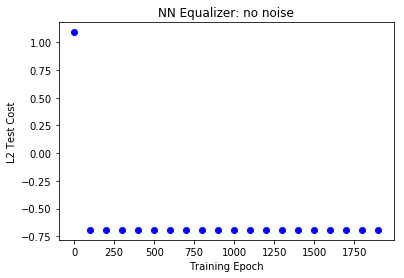

In [91]:
### CFO then Equalizer ###

import matplotlib.pyplot as plt   
import numpy as np

epochs = 2000
batch_size = 1500

#     # generate the data
#     (channel_train, channel_test, preamble_train_orig, preamble_train_cfo, preamble_test_orig, 
# preamble_test_cfo, data_train_orig,data_train_cfo,data_test_orig,data_test_cfo) = data_generation(epochs)

mc_losses = []

# define equalizer NN class object
net2 = CFO_Equalizer(preamble_length = 50, data_length = 100, channel_length = 2, 
                    batch_size=1500, learning_rate = 0.01)

for epoch in range(epochs):
    current_start = epoch*batch_size
    channel_train_batch = channel_train[current_start:(current_start+batch_size),:,:]
    data_train_cfo_batch = data_train_cfo[current_start:(current_start+batch_size),:,:]
    data_train_orig_batch = data_train_orig[current_start:(current_start+batch_size),:,:]
    preamble_train_orig_batch = preamble_train_orig[current_start:(current_start+batch_size),:,:]
    preamble_train_cfo_batch = preamble_train_cfo[current_start:(current_start+batch_size),:,:]        

    train_cost = net2.train_net(preamble_train_orig_batch, preamble_train_cfo_batch, data_train_orig_batch, 
                               data_train_cfo_batch, channel_train_batch)

    if epoch % 100 == 0: 


        test_cost, test_est, test_omega = net2.test_net(preamble_test_orig, 
                                                                  preamble_test_cfo, data_test_orig, 
                                                                  data_test_cfo, channel_test)

        mc_losses.append(test_cost)


        plt.plot(epoch, np.log(test_cost), 'bo')
        print('Epoch {}, Train Cost {}, Test Cost: {}'.format(epoch, train_cost,test_cost))


plt.xlabel('Training Epoch')
plt.ylabel('L2 Test Cost')
plt.title('NN Equalizer: no noise')
# plt.text(1000, .025, r'NN equalizer')
# plt.text(0.5, .025, r'Zero Force equalizer')
plt.show()


Epoch 0, Train Cost 0.9539691805839539, Test Cost: 0.6533547639846802
Epoch 100, Train Cost 0.4940091073513031, Test Cost: 0.49371567368507385
Epoch 200, Train Cost 0.4182162582874298, Test Cost: 0.4144271910190582
Epoch 300, Train Cost 0.23925510048866272, Test Cost: 0.2369288057088852
Epoch 400, Train Cost 0.08440049737691879, Test Cost: 0.08010869473218918
Epoch 500, Train Cost 0.5377944111824036, Test Cost: 0.5361482501029968
Epoch 600, Train Cost 0.49668964743614197, Test Cost: 0.49710613489151
Epoch 700, Train Cost 0.4910082221031189, Test Cost: 0.4900324046611786
Epoch 800, Train Cost 0.20533324778079987, Test Cost: 0.22462791204452515
Epoch 900, Train Cost 0.4886311888694763, Test Cost: 0.4878615140914917
Epoch 1000, Train Cost 0.1544889360666275, Test Cost: 0.14943507313728333
Epoch 1100, Train Cost 0.03892027214169502, Test Cost: 0.03928423300385475
Epoch 1200, Train Cost 0.5218047499656677, Test Cost: 0.5198233127593994
Epoch 1300, Train Cost 0.4949823021888733, Test Cost: 0

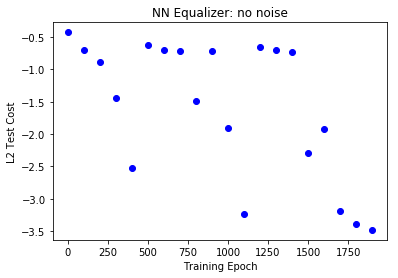

In [92]:
### Equalizer then CFO ###


import matplotlib.pyplot as plt   
import numpy as np

epochs = 2000
batch_size = 1500

#     # generate the data
#     (channel_train, channel_test, preamble_train_orig, preamble_train_cfo, preamble_test_orig, 
# preamble_test_cfo, data_train_orig,data_train_cfo,data_test_orig,data_test_cfo) = data_generation(epochs)

mc_losses = []

# define equalizer NN class object
net = Equalizer_then_CFO(preamble_length = 50, data_length = 100, channel_length = 2, 
                    batch_size=1500, learning_rate = 0.001)

for epoch in range(epochs):
    current_start = epoch*batch_size
    channel_train_batch = channel_train[current_start:(current_start+batch_size),:,:]
    data_train_cfo_batch = data_train_cfo[current_start:(current_start+batch_size),:,:]
    data_train_orig_batch = data_train_orig[current_start:(current_start+batch_size),:,:]
    preamble_train_orig_batch = preamble_train_orig[current_start:(current_start+batch_size),:,:]
    preamble_train_cfo_batch = preamble_train_cfo[current_start:(current_start+batch_size),:,:]        

    train_cost = net.train_net(preamble_train_orig_batch, preamble_train_cfo_batch, data_train_orig_batch, 
                               data_train_cfo_batch, channel_train_batch)

    if epoch % 100 == 0: 


        test_cost, test_est, test_omega, test_corr = net.test_net(preamble_test_orig, 
                                                                  preamble_test_cfo, data_test_orig, 
                                                                  data_test_cfo, channel_test)

        mc_losses.append(test_cost)


        plt.plot(epoch, np.log(test_cost), 'bo')
        print('Epoch {}, Train Cost {}, Test Cost: {}'.format(epoch, train_cost,test_cost))


plt.xlabel('Training Epoch')
plt.ylabel('L2 Test Cost')
plt.title('NN Equalizer: no noise')
# plt.text(1000, .025, r'NN equalizer')
# plt.text(0.5, .025, r'Zero Force equalizer')
plt.show()


In [79]:
k=41
print(test_est[0,:,:]-preamble_test_orig[0,:,:])

print(test_omega-omega_test)

print(test_omega[k])
print(omega_test[k])

[[ 0.16234691 -0.03970928]
 [-0.19225084 -0.17413898]
 [ 0.09435235 -0.16037185]
 [ 0.03150128  0.02534925]
 [ 0.0396372  -0.08908354]
 [ 0.26403277 -0.10009514]
 [ 0.11368872  0.07741069]
 [-0.21185086 -0.10727884]
 [-0.15390115 -0.12785102]
 [ 0.12514209  0.27123858]
 [ 0.03433518  0.11138798]
 [-0.02079661 -0.41602449]
 [-0.12422998 -0.09372808]
 [-0.18149359  0.15800654]
 [-0.12807034 -0.05179549]
 [-0.0532961   0.07174487]
 [-0.23837666  0.06719859]
 [-0.02387224  0.09061922]
 [ 0.06423442  0.28427605]
 [ 0.12809862 -0.20461286]
 [-0.09872968 -0.30257179]
 [-0.11483188  0.05212306]
 [ 0.02188127 -0.02777295]
 [-0.07905428 -0.19221901]
 [-0.06869019 -0.02545906]
 [-0.13699384  0.08126296]
 [ 0.25910215  0.26435666]
 [-0.19925035 -0.07228382]
 [-0.35770605  0.09340321]
 [ 0.1479869   0.04556532]
 [ 0.26893572  0.04971458]
 [ 0.21770821 -0.03788875]
 [ 0.10874559 -0.08441781]
 [-0.13635941  0.09711163]
 [ 0.46304437 -0.22444283]
 [ 0.15404083  0.01289208]
 [-0.0572278   0.15480952]
 